In [77]:
from IPython.display import display
import os
import pandas as pd
import pyrootutils
import matplotlib.pyplot as plt
import hydra
from nltk.tokenize import word_tokenize

pyrootutils.set_root(os.path.abspath(".."), pythonpath=True)

from src.utils.data import load_news, load_behaviors, load_users
from src.utils.notebook import get_figsize, plot_latex_style

with hydra.initialize(version_base=None, config_path="../conf"):
    cfg = hydra.compose(config_name="notebook")


In [79]:
def news_stats(variant):
    news = load_news(variant=variant, drop_duplicates=False, data_dir=cfg.data_dir)
    news = news.reset_index()
    news["title_length"] = news.title.apply(word_tokenize).str.len()
    news["abstract_length"] = news.abstract.apply(word_tokenize).str.len()
    
    aggregations = {
        'id': 'nunique',
        'category': 'nunique',
        'subcategory': 'nunique',
        'title_length': 'mean',
        'abstract_length': 'mean'
    }
    splits = news.groupby("split", sort=False).agg(aggregations)
    total = news.agg(aggregations).to_frame(name="total").T
    stats = pd.concat([splits, total])
    stats = stats.rename(columns={
        'id': 'n_articles',
        'category': 'n_categories',
        'subcategory': 'n_subcategories',
    })
    index = pd.Index(["train", "test", "dev", "total"]).intersection(stats.index)
    return stats.reindex(index)
    
news_stats("small")

,n_articles,n_categories,n_subcategories,title_length,abstract_length
train,51282.0,17.0,264.0,11.777446,38.825884
dev,42416.0,17.0,257.0,11.827117,37.458176
total,65238.0,18.0,270.0,11.799932,38.206739


In [80]:
news_stats("large")

,n_articles,n_categories,n_subcategories,title_length,abstract_length
train,101527.0,18.0,285.0,11.704128,41.092724
test,120959.0,18.0,290.0,11.738630,41.154333
dev,72023.0,17.0,269.0,11.759535,39.931952
total,130379.0,18.0,293.0,11.731849,40.834158


In [81]:
news_stats("200000_468")

,n_articles,n_categories,n_subcategories,title_length,abstract_length
train,75811.0,18.0,274.0,11.759349,40.190883
test,40525.0,17.0,258.0,11.848760,37.521752
dev,40400.0,16.0,259.0,11.845347,37.570743
total,78395.0,18.0,275.0,11.804633,38.825401


In [73]:
def impression_stats(variant):
    behaviors = load_behaviors(variant, data_dir="../data")
    behaviors["history_length"] = behaviors["history"].apply(len)
    behaviors["n_impressions"] = behaviors["impressions"].apply(len)
    behaviors["n_clicks"] = behaviors["impressions"].apply(lambda x: len([s for s in x if s.endswith("-1")]))
    
    aggregations = {
        'log_id': 'count',
        'user': 'nunique',
        'history_length': ['mean', 'median', 'min', 'max'],
        'n_impressions': ['sum', 'mean', 'median', 'min', 'max'],
        'n_clicks': ['sum', 'mean', 'median', 'min', 'max']
    }
    
    splits = behaviors.groupby("split", sort=False).agg(aggregations)
    total = behaviors.agg(aggregations).stack().to_frame(name="total").T

    total.columns = total.columns.swaplevel()
    total = total.reindex(columns=splits.columns)

    stats = pd.concat([splits, total])
    stats = stats.rename(columns={
        'log_id': 'logs',
    })
    index = pd.Index(["train", "test", "dev", "total"]).intersection(stats.index)
    return stats.reindex(index)
    
impression_stats("small")

logs     user history_length                    n_impressions  \
          count  nunique           mean median  min    max           sum   
train  156965.0  50000.0      32.539987   19.0  0.0  558.0     5843444.0   
dev     73152.0  50000.0      32.295959   19.0  0.0  444.0     2740998.0   
total  230117.0  94057.0      32.462413   19.0  0.0  558.0     8584442.0   

                                     n_clicks                              
            mean median  min    max       sum      mean median  min   max  
train  37.227688   24.0  2.0  299.0  236344.0  1.505711    1.0  1.0  35.0  
dev    37.469898   23.0  2.0  295.0  111383.0  1.522624    1.0  1.0  24.0  
total  37.304684   24.0  2.0  299.0  347727.0  1.511088    1.0  1.0  35.0

In [11]:
impression_stats("large")

logs      user history_length                     n_impressions  \
           count   nunique           mean median  min     max           sum   
train  2232748.0  711222.0      32.977241   19.0  0.0   801.0    83507374.0   
dev     376471.0  255990.0      32.624460   19.0  0.0   801.0    14085557.0   
test   2370727.0  702005.0      41.599264   25.0  0.0  1021.0    93115001.0   
total  4979946.0  876956.0      37.055127   21.0  0.0  1021.0   190707932.0   

                                      n_clicks                              
            mean median  min    max        sum      mean median  min   max  
train  37.401164   25.0  2.0  300.0  3383656.0  1.515467    1.0  1.0  51.0  
dev    37.414720   23.0  2.0  299.0   574845.0  1.526930    1.0  1.0  39.0  
test   39.276982   25.0  1.0  300.0        0.0  0.000000    0.0  0.0   0.0  
total  38.295181   25.0  1.0  300.0  3958501.0  0.794888    1.0  0.0  51.0

In [74]:
impression_stats("200000_468")

logs      user history_length                    n_impressions  \
          count   nunique           mean median  min    max           sum   
train  595996.0  189578.0      33.114566   19.0  0.0  730.0    22345505.0   
test    50078.0   40087.0      32.917888   19.0  0.0  730.0     1875016.0   
dev     50079.0   40100.0      32.670561   19.0  0.0  690.0     1876381.0   
total  696153.0  200000.0      33.068478   19.0  0.0  730.0    26096902.0   

                                      n_clicks                              
            mean median  min    max        sum      mean median  min   max  
train  37.492710   25.0  2.0  300.0   903701.0  1.516287    1.0  1.0  39.0  
test   37.441911   23.0  2.0  293.0    76684.0  1.531291    1.0  1.0  22.0  
dev    37.468420   23.0  2.0  292.0    76717.0  1.531920    1.0  1.0  25.0  
total  37.487308   24.0  2.0  300.0  1057102.0  1.518491    1.0  1.0  39.0

In [84]:
variant = "200000_468"
news = load_news(variant=variant, drop_duplicates=True, data_dir=cfg.data_dir)
users = load_users(variant=variant, data_dir=cfg.data_dir)
reads = users.explode("history").rename(columns={"history": "news_id"})
news_read = reads.merge(news, left_on="news_id", right_index=True)

In [92]:
news["title_length"] = news.title.apply(word_tokenize).str.len()
news["abstract_length"] = news.abstract.apply(word_tokenize).str.len()

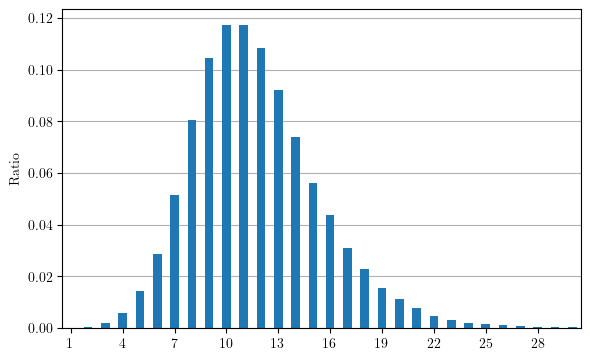

In [138]:
title_length_counts = news.title_length.value_counts().sort_index()
index = pd.RangeIndex(start=1, stop=31)
title_length_counts = title_length_counts.reindex(index, fill_value=0)
title_length_counts = title_length_counts / len(news)
with plot_latex_style():
    ax = title_length_counts.plot.bar(figsize=get_figsize(), rot=0)
    ax.set_xticks(range(0, title_length_counts.index.max(), 3))
    ax.set_ylabel("Ratio")
    ax.set_axisbelow(True)
    ax.grid(axis="y")
    plt.savefig(os.path.join(cfg.images_dir, f"title_length_distribution.pdf"), format="pdf", bbox_inches="tight")


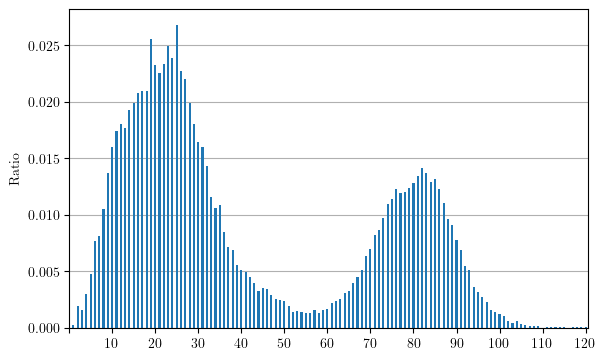

In [137]:
abstract_length_counts = news.abstract_length.value_counts().sort_index()
index = pd.RangeIndex(start=1, stop=121)
abstract_length_counts = abstract_length_counts.reindex(index, fill_value=0)
abstract_length_counts = abstract_length_counts / len(news)
with plot_latex_style():
    ax = abstract_length_counts.plot.bar(figsize=get_figsize(), rot=0)
    ax.set_xticks(range(-1, abstract_length_counts.index.max(), 10))
    ax.set_ylabel("Ratio")
    ax.set_axisbelow(True)
    ax.grid(axis="y")
    plt.savefig(os.path.join(cfg.images_dir, f"abstract_length_distribution.pdf"), format="pdf", bbox_inches="tight")


In [4]:
pie = news.category.value_counts().plot.pie(labeldistance=1.1, legend=False)
wedges, labels = pie.get_legend_handles_labels()
colors = [wedge.get_facecolor() for wedge in wedges]
color_map = dict(zip(labels, colors))
plt.clf()

<Figure size 640x480 with 0 Axes>

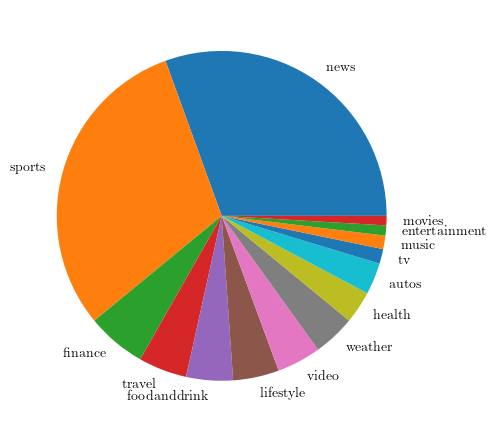

In [48]:
minimum = 100
category_count = news.category.value_counts()
included_categories = category_count[category_count >= minimum]
with plot_latex_style():
    included_categories.plot.pie(ylabel="", figsize=get_figsize(fraction=0.8, aspect_ratio=1))
    plt.savefig(os.path.join(cfg.images_dir, "topic_distribution.pdf"), format="pdf", bbox_inches="tight")


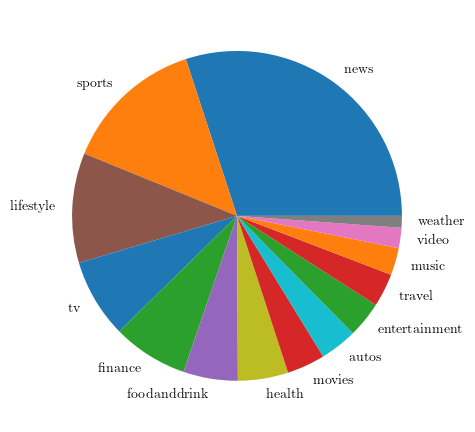

In [49]:
reads_category_count = news_reads.category.value_counts()
reads_category_count = reads_category_count[reads_category_count > 100]
colors = [color_map[label] for label in reads_category_count.keys()]
with plot_latex_style():
    reads_category_count.plot.pie(colors=colors, ylabel="", figsize=get_figsize(fraction=0.8, aspect_ratio=1))
    plt.savefig(os.path.join(cfg.images_dir, "topic_reads_distribution.pdf"), format="pdf", bbox_inches="tight")